In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from rag.pdf import PDFRetrievalChain

# PDF 문서를 로드합니다.
pdf = PDFRetrievalChain(["data/RAGwithLangChain.pdf"]).create_chain()

# retriever와 chain을 생성합니다.
pdf_retriever = pdf.retriever
pdf_chain = pdf.chain

data/RAGwithLangChain.pdf


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


### Message tools

In [3]:
def get_role_from_messages(msg):
    if isinstance(msg, HumanMessage):
        return "user"
    elif isinstance(msg, AIMessage):
        return "assistant"
    else:
        return "assistant"

def messages_to_history(messages):
    result =  "\n".join(
        [f"{get_role_from_messages(msg)}: {msg.content}" for msg in messages]
    )
    return result

### GroundednessCheck tools

In [12]:
from langchain_openai import ChatOpenAI
from rag.utils import format_docs
from langchain_core.runnables import RunnableConfig
from typing import Any, Dict, List, Callable, Optional
from pydantic import BaseModel, Field
from langchain_core.prompts import PromptTemplate

class GroundnessQuestionScore(BaseModel):
    """Binary scores for relevance checks"""

    score: str = Field(
        description="relevant or not relevant. Answer 'yes' if the answer is relevant to the question else answer 'no'"
    )

class GroundnessAnswerRetrievalScore(BaseModel):
    """Binary scores for relevance checks"""

    score: str = Field(
        description="relevant or not relevant. Answer 'yes' if the answer is relevant to the retrieved document else answer 'no'"
    )

class GroundnessQuestionRetrievalScore(BaseModel):
    """Binary scores for relevance checks"""

    score: str = Field(
        description="relevant or not relevant. Answer 'yes' if the question is relevant to the retrieved document else answer 'no'"
    )

class GroundednessChecker:
    """
    GroundednessChecker 클래스는 문서의 정확성을 평가하는 클래스입니다.

    이 클래스는 주어진 문서가 정확한지 여부를 평가합니다.
    'yes' 또는 'no' 두 가지 중 하나를 반환합니다.

    Attributes:
        llm (BaseLLM): 사용할 언어 모델 인스턴스
        target (str): 평가 대상 ('retrieval-answer', 'question-answer' 또는 'question-retrieval')
    """

    def __init__(self, llm, target="retrieval-answer"):
        """
        GroundednessChecker 클래스의 생성자입니다.

        Args:
            llm (BaseLLM): 사용할 언어 모델 인스턴스
            target (str): 평가 대상 ('retrieval-answer', 'question-answer' 또는 'question-retrieval')
        """
        self.llm = llm
        self.target = target

    def create(self):
        """
        정확성 평가를 위한 체인을 생성합니다.

        Returns:
            Chain: 정확성 평가를 수행할 수 있는 체인 객체
        """
        # 파서
        if self.target == "retrieval-answer":
            llm = self.llm.with_structured_output(GroundnessAnswerRetrievalScore)
        elif self.target == "question-answer":
            llm = self.llm.with_structured_output(GroundnessQuestionScore)
        elif self.target == "question-retrieval":
            llm = self.llm.with_structured_output(GroundnessQuestionRetrievalScore)
        else:
            raise ValueError(f"Invalid target: {self.target}")

        # 프롬프트 선택
        if self.target == "retrieval-answer":
            template = """You are a grader assessing relevance of a retrieved document to a user question. \n 
                Here is the retrieved document: \n\n {context} \n\n
                Here is the answer: {answer} \n
                If the document contains keyword(s) or semantic meaning related to the user answer, grade it as relevant. \n
                
                Give a binary score 'yes' or 'no' score to indicate whether the retrieved document is relevant to the answer."""
            input_vars = ["context", "answer"]

        elif self.target == "question-answer":
            template = """You are a grader assessing whether an answer appropriately addresses the given question. \n
                Here is the question: \n\n {question} \n\n
                Here is the answer: {answer} \n
                If the answer directly addresses the question and provides relevant information, grade it as relevant. \n
                Consider both semantic meaning and factual accuracy in your assessment. \n
                
                Give a binary score 'yes' or 'no' score to indicate whether the answer is relevant to the question."""
            input_vars = ["question", "answer"]

        elif self.target == "question-retrieval":
            template = """You are a grader assessing whether a retrieved document is relevant to the given question. \n
                Here is the question: \n\n {question} \n\n
                Here is the retrieved document: \n\n {context} \n
                If the document contains information that could help answer the question, grade it as relevant. \n
                Consider both semantic meaning and potential usefulness for answering the question. \n
                
                Give a binary score 'yes' or 'no' score to indicate whether the retrieved document is relevant to the question."""
            input_vars = ["question", "context"]

        else:
            raise ValueError(f"Invalid target: {self.target}")

        # 프롬프트 생성
        prompt = PromptTemplate(
            template=template,
            input_variables=input_vars,
        )

        # 체인
        chain = prompt | llm
        return chain



### Invoking / Streaming funcs

In [13]:
from langgraph.graph.state import CompiledStateGraph
def stream_graph(
    graph: CompiledStateGraph,
    inputs: dict,
    config: RunnableConfig,
    node_names: List[str] = [],
    callback: Callable = None,
):
    """
    LangGraph의 실행 결과를 스트리밍하여 출력하는 함수입니다.

    Args:
        graph (CompiledStateGraph): 실행할 컴파일된 LangGraph 객체
        inputs (dict): 그래프에 전달할 입력값 딕셔너리
        config (RunnableConfig): 실행 설정
        node_names (List[str], optional): 출력할 노드 이름 목록. 기본값은 빈 리스트
        callback (Callable, optional): 각 청크 처리를 위한 콜백 함수. 기본값은 None
            콜백 함수는 {"node": str, "content": str} 형태의 딕셔너리를 인자로 받습니다.

    Returns:
        None: 함수는 스트리밍 결과를 출력만 하고 반환값은 없습니다.
    """
    prev_node = ""
    for chunk_msg, metadata in graph.stream(inputs, config, stream_mode="messages"):
        curr_node = metadata["langgraph_node"]

        # node_names가 비어있거나 현재 노드가 node_names에 있는 경우에만 처리
        if not node_names or curr_node in node_names:
            # 콜백 함수가 있는 경우 실행
            if callback:
                callback({"node": curr_node, "content": chunk_msg.content})
            # 콜백이 없는 경우 기본 출력
            else:
                # 노드가 변경된 경우에만 구분선 출력
                if curr_node != prev_node:
                    print("\n" + "=" * 50)
                    print(f"🔄 Node: \033[1;36m{curr_node}\033[0m 🔄")
                    print("- " * 25)
                print(chunk_msg.content, end="", flush=True)

            prev_node = curr_node


def invoke_graph(
    graph: CompiledStateGraph,
    inputs: dict,
    config: RunnableConfig,
    node_names: List[str] = [],
    callback: Callable = None,
):
    """
    LangGraph 앱의 실행 결과를 예쁘게 스트리밍하여 출력하는 함수입니다.

    Args:
        graph (CompiledStateGraph): 실행할 컴파일된 LangGraph 객체
        inputs (dict): 그래프에 전달할 입력값 딕셔너리
        config (RunnableConfig): 실행 설정
        node_names (List[str], optional): 출력할 노드 이름 목록. 기본값은 빈 리스트
        callback (Callable, optional): 각 청크 처리를 위한 콜백 함수. 기본값은 None
            콜백 함수는 {"node": str, "content": str} 형태의 딕셔너리를 인자로 받습니다.

    Returns:
        None: 함수는 스트리밍 결과를 출력만 하고 반환값은 없습니다.
    """

    def format_namespace(namespace):
        return namespace[-1].split(":")[0] if len(namespace) > 0 else "root graph"

    # subgraphs=True 를 통해 서브그래프의 출력도 포함
    for namespace, chunk in graph.stream(
        inputs, config, stream_mode="updates", subgraphs=True
    ):
        for node_name, node_chunk in chunk.items():
            # node_names가 비어있지 않은 경우에만 필터링
            if len(node_names) > 0 and node_name not in node_names:
                continue

            # 콜백 함수가 있는 경우 실행
            if callback is not None:
                callback({"node": node_name, "content": node_chunk})
            # 콜백이 없는 경우 기본 출력
            else:
                print("\n" + "=" * 50)
                formatted_namespace = format_namespace(namespace)
                if formatted_namespace == "root graph":
                    print(f"🔄 Node: \033[1;36m{node_name}\033[0m 🔄")
                else:
                    print(
                        f"🔄 Node: \033[1;36m{node_name}\033[0m in [\033[1;33m{formatted_namespace}\033[0m] 🔄"
                    )
                print("- " * 25)

                # 노드의 청크 데이터 출력
                if isinstance(node_chunk, dict):
                    for k, v in node_chunk.items():
                        if isinstance(v, BaseMessage):
                            v.pretty_print()
                        elif isinstance(v, list):
                            for list_item in v:
                                if isinstance(list_item, BaseMessage):
                                    list_item.pretty_print()
                                else:
                                    print(list_item)
                        elif isinstance(v, dict):
                            for node_chunk_key, node_chunk_value in node_chunk.items():
                                print(f"{node_chunk_key}:\n{node_chunk_value}")
                        else:
                            print(f"\033[1;32m{k}\033[0m:\n{v}")
                else:
                    if node_chunk is not None:
                        for item in node_chunk:
                            print(item)
                print("=" * 50)

### Search tool

In [14]:
from langchain_core.tools import BaseTool
from pydantic import BaseModel, Field
from tavily import TavilyClient
from typing import Literal, Sequence, Optional, List
import json
import os


class TavilySearchInput(BaseModel):
    """Input for the Tavily tool."""

    query: str = Field(description="검색 쿼리")


def format_search_result(result: dict, include_raw_content: bool = False) -> str:
    """
    Utility functions for formatting search results.

    Args:
        result (dict): 원본 검색 결과

    Returns:
        str: XML 형식으로 포맷팅된 검색 결과
    """
    # 한글 인코딩 처리를 위해 json.dumps() 사용
    title = json.dumps(result["title"], ensure_ascii=False)[1:-1]
    content = json.dumps(result["content"], ensure_ascii=False)[1:-1]
    raw_content = ""
    if (
        include_raw_content
        and "raw_content" in result
        and result["raw_content"] is not None
        and len(result["raw_content"].strip()) > 0
    ):
        raw_content = f"<raw>{result['raw_content']}</raw>"

    return f"<document><title>{title}</title><url>{result['url']}</url><content>{content}</content>{raw_content}</document>"


class TavilySearch(BaseTool):
    """
    Tool that queries the Tavily Search API and gets back json
    """

    name: str = "tavily_web_search"
    description: str = (
        "A search engine optimized for comprehensive, accurate, and trusted results. "
        "Useful for when you need to answer questions about current events. "
        "Input should be a search query. [IMPORTANT] Input(query) should be over 5 characters."
    )
    args_schema: type[BaseModel] = TavilySearchInput
    client: TavilyClient = None
    include_domains: list = []
    exclude_domains: list = []
    max_results: int = 3
    topic: Literal["general", "news"] = "general"
    days: int = 3
    search_depth: Literal["basic", "advanced"] = "basic"
    include_answer: bool = False
    include_raw_content: bool = True
    include_images: bool = False
    format_output: bool = False

    def __init__(
        self,
        api_key: Optional[str] = None,
        include_domains: list = [],
        exclude_domains: list = [],
        max_results: int = 3,
        topic: Literal["general", "news"] = "general",
        days: int = 3,
        search_depth: Literal["basic", "advanced"] = "basic",
        include_answer: bool = False,
        include_raw_content: bool = True,
        include_images: bool = False,
        format_output: bool = False,
    ):
        """
        TavilySearch 클래스의 인스턴스를 초기화합니다.

        Args:
            api_key (str): Tavily API 키
            include_domains (list): 검색에 포함할 도메인 목록
            exclude_domains (list): 검색에서 제외할 도메인 목록
            max_results (int): 기본 검색 결과 수
        """
        super().__init__()
        if api_key is None:
            api_key = os.environ.get("TAVILY_API_KEY", None)

        if api_key is None:
            raise ValueError("Tavily API key is not set.")

        self.client = TavilyClient(api_key=api_key)
        self.include_domains = include_domains
        self.exclude_domains = exclude_domains
        self.max_results = max_results
        self.topic = topic
        self.days = days
        self.search_depth = search_depth
        self.include_answer = include_answer
        self.include_raw_content = include_raw_content
        self.include_images = include_images
        self.format_output = format_output

    def _run(self, query: str) -> str:
        """BaseTool의 _run 메서드 구현"""
        results = self.search(query)
        return results
        # return json.dumps(results, ensure_ascii=False)

    def search(
        self,
        query: str,
        search_depth: Literal["basic", "advanced"] = None,
        topic: Literal["general", "news"] = None,
        days: int = None,
        max_results: int = None,
        include_domains: Sequence[str] = None,
        exclude_domains: Sequence[str] = None,
        include_answer: bool = None,
        include_raw_content: bool = None,
        include_images: bool = None,
        format_output: bool = None,
        **kwargs,
    ) -> list:
        """
        검색을 수행하고 결과를 반환합니다.

        Args:
            query (str): 검색 쿼리
            search_depth (str): 검색 깊이 ("basic" 또는 "advanced")
            topic (str): 검색 주제 ("general" 또는 "news")
            days (int): 검색할 날짜 범위
            max_results (int): 최대 검색 결과 수
            include_domains (list): 검색에 포함할 도메인 목록
            exclude_domains (list): 검색에서 제외할 도메인 목록
            include_answer (bool): 답변 포함 여부
            include_raw_content (bool): 원본 콘텐츠 포함 여부
            include_images (bool): 이미지 포함 여부
            format_output (bool): 결과를 포맷팅할지 여부
            **kwargs: 추가 키워드 인자

        Returns:
            list: 검색 결과 목록
        """
        # 기본값 설정
        params = {
            "query": query,
            "search_depth": search_depth or self.search_depth,
            "topic": topic or self.topic,
            "max_results": max_results or self.max_results,
            "include_domains": include_domains or self.include_domains,
            "exclude_domains": exclude_domains or self.exclude_domains,
            "include_answer": (
                include_answer if include_answer is not None else self.include_answer
            ),
            "include_raw_content": (
                include_raw_content
                if include_raw_content is not None
                else self.include_raw_content
            ),
            "include_images": (
                include_images if include_images is not None else self.include_images
            ),
            **kwargs,
        }

        # days 파라미터 처리
        if days is not None:
            if params["topic"] == "general":
                print(
                    "Warning: days parameter is ignored for 'general' topic search. Set topic parameter to 'news' to use days."
                )
            else:
                params["days"] = days

        # API 호출
        response = self.client.search(**params)

        # 결과 포맷팅
        format_output = (
            format_output if format_output is not None else self.format_output
        )
        if format_output:
            return [
                format_search_result(r, params["include_raw_content"])
                for r in response["results"]
            ]
        else:
            return response["results"]

    def get_search_context(
        self,
        query: str,
        search_depth: Literal["basic", "advanced"] = "basic",
        topic: Literal["general", "news"] = "general",
        days: int = 3,
        max_results: int = 5,
        include_domains: Sequence[str] = None,
        exclude_domains: Sequence[str] = None,
        max_tokens: int = 4000,
        format_output: bool = True,
        **kwargs,
    ) -> str:
        """
        검색 쿼리에 대한 컨텍스트를 가져옵니다. 웹사이트에서 관련 콘텐츠만 가져오는 데 유용하며,
        컨텍스트 추출과 제한을 직접 처리할 필요가 없습니다.

        Args:
            query (str): 검색 쿼리
            search_depth (str): 검색 깊이 ("basic" 또는 "advanced")
            topic (str): 검색 주제 ("general" 또는 "news")
            days (int): 검색할 날짜 범위
            max_results (int): 최대 검색 결과 수
            include_domains (list): 검색에 포함할 도메인 목록
            exclude_domains (list): 검색에서 제외할 도메인 목록
            max_tokens (int): 반환할 최대 토큰 수 (openai 토큰 계산 기준). 기본값은 4000입니다.
            format_output (bool): 결과를 포맷팅할지 여부
            **kwargs: 추가 키워드 인자

        Returns:
            str: 컨텍스트 제한까지의 검색 컨텍스트를 포함하는 JSON 문자열
        """
        response = self.client.search(
            query,
            search_depth=search_depth,
            topic=topic,
            days=days,
            max_results=max_results,
            include_domains=include_domains,
            exclude_domains=exclude_domains,
            include_answer=False,
            include_raw_content=False,
            include_images=False,
            **kwargs,
        )

        sources = response.get("results", [])
        if format_output:
            context = [
                format_search_result(source, include_raw_content=False)
                for source in sources
            ]
        else:
            context = [
                {
                    "url": source["url"],
                    "content": json.dumps(
                        {"title": source["title"], "content": source["content"]},
                        ensure_ascii=False,
                    ),
                }
                for source in sources
            ]

        # max_tokens 처리 로직은 여기에 구현해야 합니다.
        # 현재는 간단히 모든 컨텍스트를 반환합니다.
        return json.dumps(context, ensure_ascii=False)


## State Definition

In [36]:
from langgraph.graph import MessagesState
from typing import Annotated
from langgraph.graph.message import add_messages

class GraphState(MessagesState):
    # messages: Annotated[list, add_messages] # pre-built in MessagesState
    question: Annotated[List[str], add_messages]  # 질문(누적되는 list)
    context: Annotated[str, "Context"]
    answer: Annotated[str, "Answer"]
    relevance: Annotated[str, "Relevance"]

## Node Definition

In [47]:
# 문서 검색 노드
def retrieve_document(state: GraphState) -> GraphState:
    latest_question = state["question"][-1].content

    retrieved_docs = pdf_retriever.invoke(latest_question)
    retrieved_docs = format_docs(retrieved_docs)

    return GraphState(context=retrieved_docs)

# 답변 생성 노드
def llm_answer(state: GraphState) -> GraphState:
    latest_question = state["question"][-1].content
    context = state["context"]

    response = pdf_chain.invoke(
        {
            "question": latest_question,
            "context": context,
            "chat_history": messages_to_history(state["messages"])
        }
    )

    return {
        "answer": response,
        "messages": [("user", latest_question), ("assistant", response)],
    }

def relevance_check(state: GraphState) -> GraphState:
    question_retrieval_relevance_checker = GroundednessChecker(
        llm=ChatOpenAI(model="gpt-4o-mini", temperature=0), target="question-retrieval"
    ).create()

    response = question_retrieval_relevance_checker.invoke(
        {"question":state["question"][-1].content, "context":state["context"]}
    )

    print("=== [RELEVENCE CHECKING] ===")

    return {"relevance":response.score}

def is_relevant(state: GraphState) -> GraphState:
    if state["relevance"] == "yes":
        return "relevant"
    else:
        return "not relevant"


## Web Search Node

In [14]:
tavily_tool = TavilySearch()

search_query = "RAG를 만든 사람은?"

search_result = tavily_tool.search(
    query=search_query,
    max_result = 2,
    format_output = True
)

print(search_result)

['<document><title>[Ai 리뷰] 생성 Ai 모델, 정확성과 신뢰성 향상시키는 \'검색 증강 생성(Rag)\'은 무엇인가?</title><url>https://www.aitimes.kr/news/articleView.html?idxno=29431</url><content>\'RAG\' 단어를 만든 코히어(Cohere) 자연어 처리 연구원 패트릭 루이스(Patrick Lewis) 박사(사진:영상 갈무리) ... RAG를 언급했을 2020년에 패트릭 루이스는 유니버시티 칼리지 런던에서 NLP 박사 학위를 취득하고 런던의 새로운 AI 연구소에서 메타를 위해 일하고 있었다</content><raw>상단영역\n\n\n\n본문영역\n\n현재위치\n\n[AI 리뷰] 생성\xa0AI 모델, 정확성과 신뢰성 향상시키는  \'검색 증강 생성(RAG)\'은 무엇인가?\n\nSNS 기사보내기\n\n패트릭 루이스는 RAG를 ‘범용 미세 조정 레시피’라고 칭했다. 이는 RAG가 거의 모든 LLM에서 모든 외부 리소스와 연결하는 데 사용...\n\n생성 AI의 최근 발전을 더 현실적으로 이해하기 위해 법정의 모습을 생각해 볼 수 있다.\n\n예를 들어, 판사는 법에 대한 일반적인 이해를 바탕으로 사건을 심리하고 판결한다. 의료 과실 소송이나 노동 분쟁과 같이 특별한 전문 지식이 필요한 사건의 경우, 판사는 법원 서기관에게 인용할 수 있는 판례와 구체적인 사례를 찾게 한다.\n\n훌륭한 판사처럼 대형언어모델(LLM)은 다양한 사람의 질의에 응답할 수 있다. 하지만 출처가 정확한 신뢰할 수 있는 답변을 제공하려면, 조사를 수행할 조수가 필요하다.\n\n바로 \'검색 증강 생성(Retrieval Augmented Generation. 이하, RAG)\'라고 하는 프로세스가 AI처럼 법원 서기관의 역할을 한다.\n\n현재, 기업용 인공지능에 중점을 두고 LLM을 전문으로 하는 캐나다 다국적 AI 스타트업 \'코히어(Cohere)\'에서 RAG팀을 이끌고 있는 패트릭 루이스(Pat

In [38]:
def web_search(state: GraphState) -> GraphState:
    tavily_tool = TavilySearch()
    search_query = state["question"][-1].content

    search_result = tavily_tool.search(
        query = search_query,
        topic = "general",
        max_results = 2,
        format_output = True,
    )

    return {"context": search_result}

## Query Rewrite Node

In [9]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

rewrite_prompt = PromptTemplate(
    template = """
        Reformulate the given question to enhance its effectiveness for vectorstore retrieval.

        - Analyze the initial question to identify areas for improvement such as specificity, clarity, and relevance.
        - Consider the context and potential keywords that would optimize retrieval.
        - Maintain the intent of the original question while enhancing its structure and vocabulary.
        
        # Steps
        
        1. **Understand the Original Question**: Identify the core intent and any keywords.
        2. **Enhance Clarity**: Simplify language and ensure the question is direct and to the point.
        3. **Optimize for Retrieval**: Add or rearrange keywords for better alignment with vectorstore indexing.
        4. **Review**: Ensure the improved question accurately reflects the original intent and is free of ambiguity.
        
        # Output Format
        
        - Provide a single, improved question.
        - Do not include any introductory or explanatory text; only the reformulated question.
        
        # Examples
        
        **Input**: 
        "What are the benefits of using renewable energy sources over fossil fuels?"
        
        **Output**: 
        "How do renewable energy sources compare to fossil fuels in terms of benefits?"
        
        **Input**: 
        "How does climate change impact polar bear populations?"
        
        **Output**: 
        "What effects does climate change have on polar bear populations?"
        
        # Notes
        
        - Ensure the improved question is concise and contextually relevant.
        - Avoid altering the fundamental intent or meaning of the original question.
        
        
        [REMEMBER] Re-written question should be in the same language as the original question.
        
        # Here is the original question that needs to be rewritten:
        {question}
        """,
        input_variables=["generation", "question"],
)

query_rewriter = (
    rewrite_prompt | ChatOpenAI(model="gpt-4o-mini", temperature=0) | StrOutputParser()
)

In [10]:
query = "RAG의 발전 과정"
query_rewriter.invoke({"question":query})

'RAG의 발전 과정은 어떻게 이루어졌나요?'

In [43]:
def query_rewrite(state: GraphState) -> GraphState:
    latest_question = state["question"][-1].content
    query_rewritten = query_rewriter.invoke({"question": latest_question})
    print("Rewritten query: ", query_rewritten)
    return {"question": query_rewritten}

## Graph Definition

In [48]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(GraphState)

workflow.add_node("retrieve", retrieve_document)
workflow.add_node("relevance_check", relevance_check)
workflow.add_node("llm_answer", llm_answer)
workflow.add_node("web_search", web_search)
workflow.add_node("query_rewrite", query_rewrite)


workflow.add_edge("query_rewrite", "retrieve")
workflow.add_edge("retrieve", "relevance_check")

workflow.add_conditional_edges(
    "relevance_check",
    is_relevant,
    {
        "relevant":"llm_answer",
        "not relevant":"web_search",
    },
)

workflow.add_edge("web_search", "llm_answer")
workflow.add_edge("llm_answer", END)

workflow.set_entry_point("query_rewrite")

memory = MemorySaver()

app = workflow.compile(checkpointer=memory)

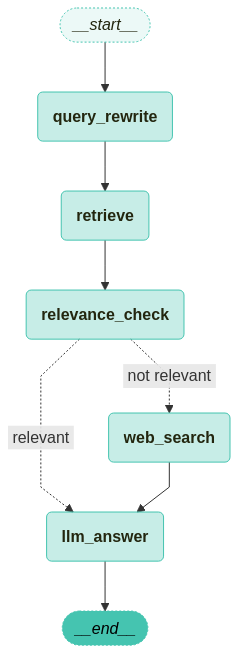

In [49]:
from utils.visualize import visualize_graph
visualize_graph(app)

## Graph Execution

### Invoking

In [50]:
from langchain_core.runnables import RunnableConfig
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.errors import GraphRecursionError

config = RunnableConfig(recursion_limit=10, configurable={"thread_id": "1"})

user_input = GraphState(question="RAG의 발전 과정")

try:
    invoke_graph(app, user_input, config, ["relevance_check", "llm_answer"])
except GraphRecursionError as recursion_error:
    print(f"GraphRecursionError: {recursion_error}")

Rewritten query:  RAG의 발전 과정은 어떻게 이루어졌나요?
=== [RELEVENCE CHECKING] ===

🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
relevance:
no

🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
answer:
RAG(리트리벌-어그멘티드 제너레이션)의 발전 과정은 크게 세 단계로 나눌 수 있습니다: 

1. **Naive RAG**: 기본적인 정보 검색과 생성 통합을 목표로 하며, 색인화된 데이터를 사용해 관련 정보를 검색하고 응답을 생성합니다. 그러나 정확도와 재현율 문제로 인해 한계가 있었습니다.

2. **Advanced RAG**: Naive RAG의 한계를 극복하기 위해 사전 검색 및 사후 검색 전략을 도입하여 정밀도를 향상시킵니다. 쿼리 최적화와 동적 임베딩을 통해 검색 품질을 높입니다.

3. **Modular RAG**: 다양한 모듈을 통합하여 적응성과 다목적성을 제공합니다. 각 모듈이 특정 작업을 담당하여 복잡한 쿼리에 대해 유연하게 응답할 수 있습니다.

이러한 발전을 통해 RAG는 LLM의 한계를 극복하고 정보의 정확성과 신뢰성을 높이는 데 기여하고 있습니다.

**Source**
- [대규모 언어 모델의 RAG 이해와 발전 방향 - sp-datalab.com](https://sp-datalab.com/entry/대규모-언어-모델의-RAG-이해와-발전-방향) 
- [RAG 기술이 LLM의 한계를 극복하는 방법 - sp-datalab.com](https://sp-datalab.com/entry/RAG-기술이-LLM의-한계를-극복하는-방법)
('user', 'RAG의 발전 과정은 어떻게 이루어졌나요?')
('assistant', 'RAG(리트리벌-어그멘티드 제너레이션)의 발전 과정은 크게 세 단계로 나눌 수 있습니다: \n

### Streaming

In [51]:
try:
    stream_graph(app, user_input, config, ["relevance_check", "llm_answer"])
except GraphRecursionError as recursion_error:
    print(f"GraphRecursionError: {recursion_error}")

Rewritten query:  RAG의 발전 과정은 어떻게 이루어졌나요?

🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
{"score":"no"}=== [RELEVENCE CHECKING] ===

🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
RAG(리트리벌-어그멘티드 제너레이션)의 발전 과정은 세 가지 단계로 나눌 수 있습니다:

1. **Naive RAG**: 기본적인 정보 검색과 생성 통합을 목표로 하며, 색인화된 데이터를 사용해 관련 정보를 검색하고 응답을 생성합니다. 그러나 정확도와 재현율 문제로 한계가 있었습니다.

2. **Advanced RAG**: Naive RAG의 한계를 극복하기 위해 사전 검색 및 사후 검색 전략을 도입하여 정밀도를 향상시킵니다. 텍스트 세분화와 메타데이터 추가를 통해 검색 품질을 높입니다.

3. **Modular RAG**: 다양한 모듈을 통합하여 적응성과 다목적성을 제공합니다. 각 모듈이 특정 작업을 담당하여 복잡한 쿼리에 대해 유연하게 응답할 수 있습니다.

이러한 발전을 통해 RAG는 LLM의 한계를 극복하고 정보의 정확성과 신뢰성을 높이는 데 기여하고 있습니다.

**Source**
- [대규모 언어 모델의 RAG 이해와 발전 방향 - sp-datalab.com](https://sp-datalab.com/entry/대규모-언어-모델의-RAG-이해와-발전-방향)
- [RAG 기술이 LLM의 한계를 극복하는 방법 - sp-datalab.com](https://sp-datalab.com/entry/RAG-기술이-LLM의-한계를-극복하는-방법)

### Output Check

In [52]:
output = app.get_state(config).values

print(f'Question: {output["question"]}')
print("===" * 30)
print(f'Answer: {output["answer"]}')


Question: [HumanMessage(content='RAG의 발전 과정', additional_kwargs={}, response_metadata={}, id='53a70483-5678-419d-b47a-27373d2ab41a'), HumanMessage(content='RAG의 발전 과정은 어떻게 이루어졌나요?', additional_kwargs={}, response_metadata={}, id='8c33fb77-6070-46a7-9997-a135cdf2c788'), HumanMessage(content='RAG의 발전 과정', additional_kwargs={}, response_metadata={}, id='2b18a111-72b0-4f78-89df-2aaea219aaef'), HumanMessage(content='RAG의 발전 과정은 어떻게 이루어졌나요?', additional_kwargs={}, response_metadata={}, id='da9d809b-ba5a-47b6-9457-9b603823c44f')]
Answer: RAG(리트리벌-어그멘티드 제너레이션)의 발전 과정은 세 가지 단계로 나눌 수 있습니다:

1. **Naive RAG**: 기본적인 정보 검색과 생성 통합을 목표로 하며, 색인화된 데이터를 사용해 관련 정보를 검색하고 응답을 생성합니다. 그러나 정확도와 재현율 문제로 한계가 있었습니다.

2. **Advanced RAG**: Naive RAG의 한계를 극복하기 위해 사전 검색 및 사후 검색 전략을 도입하여 정밀도를 향상시킵니다. 텍스트 세분화와 메타데이터 추가를 통해 검색 품질을 높입니다.

3. **Modular RAG**: 다양한 모듈을 통합하여 적응성과 다목적성을 제공합니다. 각 모듈이 특정 작업을 담당하여 복잡한 쿼리에 대해 유연하게 응답할 수 있습니다.

이러한 발전을 통해 RAG는 LLM의 한계를 극복하고 정보의 정확성과 신뢰성을 높이는 데 기여하고 있습니다.

**Source**
- [대규모 언어 모델의 